## Imports

In [ ]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import torch

## Loss function

In [108]:
# MMR method implemented
def newton(loss_fn, x0, lr=0.1, iteration=100, convergence=0.0001):
    x = x0
    for i in range(iteration):
        
        loss = loss_fn(x)
        # retain graph to calculate hessian
        loss.backward(retain_graph=True)
        
        # Newton step
        hessian = torch.autograd.functional.hessian(loss_fn, x)
        hessian_inv = torch.inverse(hessian)
        grad = torch.autograd.grad(loss, x)
        newton_step = -torch.matmul(hessian_inv, grad[0])
        
        # Line search
        alpha = 1
        while loss_fn(x + alpha*newton_step) > loss_fn(x) + lr*alpha*torch.matmul(grad[0], newton_step):
            alpha *= 0.5
            
        x = x + alpha*newton_step
        
        if torch.norm(alpha*newton_step) < convergence:
            break
            
        #if i % 10 == 0:
        print(f"Iteration {i}: {loss.item()}")   
            
    return x

def mmr_newton(data, k):
    x_data = torch.tensor(data[0])
    y_data = torch.tensor(data[1])
    
    k_evaluated_at_data_points = torch.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            k_evaluated_at_data_points[i, j] = k(x_data[i], y_data[j])
    
    def trial_function_evaluated_at_data_points(a, b):
        result = torch.zeros_like(a)
        result += b
        for i in range(len(a)):
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result
    
    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        y_trial = trial_function_evaluated_at_data_points(a, b)
        result = torch.sum((y_data-y_trial)**2)
        return result
    
    x0 = torch.tensor([torch.sum(x_data)/len(x_data), *torch.zeros_like(y_data)], requires_grad=True)
    
    minimization = newton(loss_function, x0, iteration=100).clone().detach().numpy()
    
    b = minimization[0]
    a = minimization[1:]
    
    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function

## Kernel

### Kernel library

In [109]:
#classical kernel, k(x, y) = exp(-(x-y)**2/(2*sigma**2))
def K_classical(sigma):
    def k(x, y):
        return np.exp(-(x-y)**2/(2*sigma**2))
    return k

#quantum kernel with a single Rx gate on every qubit as a feature map
def K_simple_RX(N):
    def U(x):
        for n in range(N):
            qml.RX(x, wires=n)

    def U_dagger(x):
        for n in range(N):
            qml.RX(-x, wires=n)
   
    @qml.qnode(qml.device('default.qubit', wires=N), interface="torch")
    def kernel_circuit(x, y):
        U(y)
        U_dagger(x)
        return qml.probs(wires=range(N))
    
    def k(x, y):
        return kernel_circuit(x, y)[0]
    
    return k

### Visualize Kernel

In [110]:
def kernel_subplot(ax, k, N, grid_res=15):
    xs = np.linspace(0, 2*np.pi, grid_res)
    KK = np.array([[k(x, y) for x in xs] for y in xs])

    ax.set_title(rf"$\kappa(x, y)$ for $N={N}$ qubits")
    ax.imshow(KK, extent=(0, 2*np.pi, 0, 2*np.pi))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])

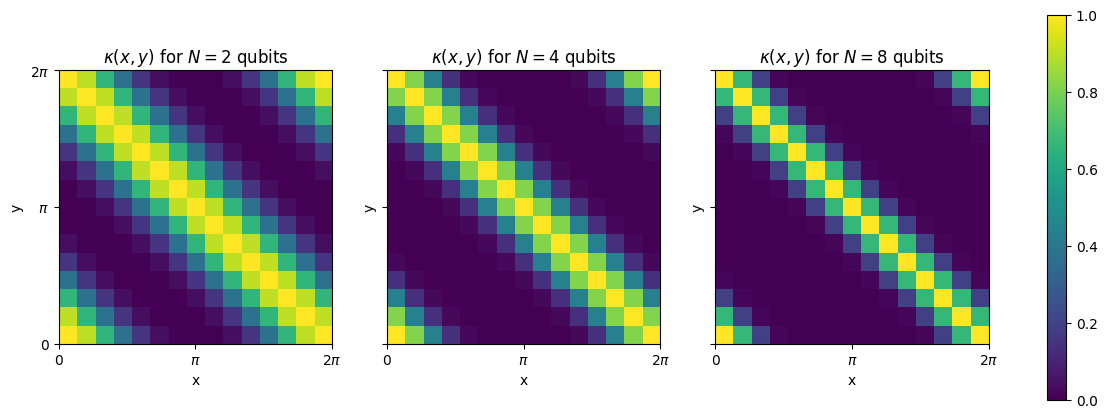

In [111]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
k = K_simple_RX(2)
kernel_subplot(axs[0], k, 2)
k = K_simple_RX(4)
kernel_subplot(axs[1], k, 4)
k = K_simple_RX(8)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

## Results

### $f(x) = x^2$

In [112]:
x = np.linspace(0, 0.1, 51)
y = x**2
data = np.array([x, y])

Iteration 0: 0.11138066664000001
Iteration 1: 1.2577094319384537e-07
Iteration 2: 1.2574731991964947e-07
Iteration 3: 1.2574701509588315e-07


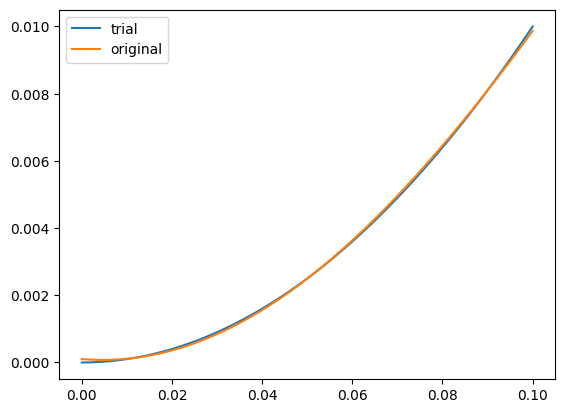

In [113]:
k = K_classical(0.14)
f = mmr_newton(data, k)
plt.plot(x, y, label="trial")
plt.plot(x, np.array([f(x) for x in x]), label="original")
plt.legend()

Iteration 0: 0.11138066664000001
Iteration 1: 3.4838719219593296e-09
Iteration 2: 7.872808648543846e-10
Iteration 3: 7.612311182149245e-10


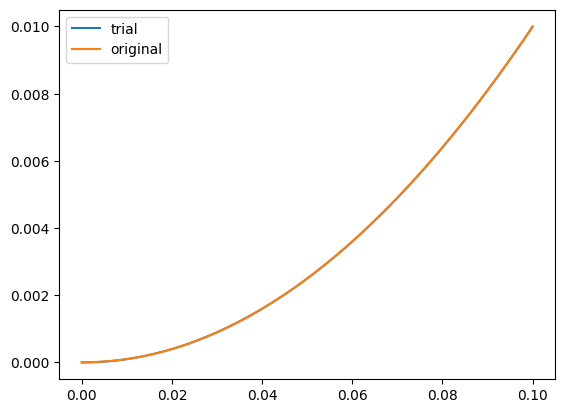

In [114]:
k = K_simple_RX(8)
f = mmr_newton(data, k)
plt.plot(x, y, label="trial")
plt.plot(x, np.array([f(x) for x in x]), label="original")
plt.legend()